Results
---

06.04.2022  
* Dataset: "complete" (50 features):  
    * 23 items of FFMQ  
    * 20 items of UPPS-P  
    * 5 items of DMQ-coping  
    * 1 item for weekly working hours  
    * 1 item for sex 
    
* Tested regressors:
    * ElasticNet (scikit-learn)  
    * ExtraTreesRegressor (scikit-learn)  
    * LGBMRegressor (lightgbm)  

## model scores

In [4]:
import pandas as pd

#results_path = "./results/2022-03-31_10-06-05/"
results_path = "./results/2022-04-05_12-15-16/"
results = pd.read_csv(results_path + "report.csv", sep=";", encoding="latin1",index_col=["Type","Split"]).sort_index()
results_grp = results.groupby("Type").mean()[["Train score (R²)","Test score (R²)"]].sort_values("Test score (R²)",ascending=False)

hline =  "\n------------------------------------------\n"
hdline = "\n==========================================\n"

print("(train R², test R²)")

for reg in results.index.levels[0]:
    print(hdline,"# "+reg + "  => ",format(results_grp.loc[reg][0],".3f")+", "+format(results_grp.loc[reg][1],".3f"),"(mean)",hdline)
    for split in results.index.levels[1]:
        print(hline,"## Split",str(split) + "  => ",format(results.loc[(reg,split)][1],".3f")+", "+format(results.loc[(reg,split)][2],".3f"),hline)
        print(results.loc[(reg,split),"Model"].replace("(","").replace(")","").replace(reg,"").replace(" ","").replace(",","\n").replace("\n\n","\n"))

(train R², test R²)

 # ElasticNet  =>  0.420, 0.314 (mean) 


------------------------------------------
 ## Split 1  =>  0.391, 0.342 
------------------------------------------

alpha=0.1930248160855201
l1_ratio=1.0

------------------------------------------
 ## Split 2  =>  0.425, 0.332 
------------------------------------------

alpha=0.14332784423473163
l1_ratio=0.9702466515983209

------------------------------------------
 ## Split 3  =>  0.433, 0.269 
------------------------------------------

alpha=0.18274773915108847
l1_ratio=1.0

------------------------------------------
 ## Split 4  =>  0.431, 0.295 
------------------------------------------

alpha=0.47667743450988187
l1_ratio=0.001

------------------------------------------
 ## Split 5  =>  0.432, 0.317 
------------------------------------------

alpha=0.16427971585398174
l1_ratio=1.0

------------------------------------------
 ## Split 6  =>  0.433, 0.332 
------------------------------------------

alpha=0.12763

## feature importance

In [5]:
import os
import json
import numpy as np
from get_data import get_mindfulness as get_data

json_files = [file for file in os.listdir(results_path) if file.lower()[-5:]==".json"]
X,_ = get_data("complete")
features = list(X.columns)
fi_types = ["m_imp","s_imp"]

# create empty dictionary tree
feature_importance = dict()
for reg in results.index.levels[0]:
    feature_importance[reg] = dict()
    for split in results.index.levels[1]:
        feature_importance[reg][split] = dict()
        for x_imp in fi_types:
            feature_importance[reg][split][x_imp] = dict()
            
# fill dictionary
for json_f in json_files:
    with open(results_path + json_f, "r") as fo:
        feat_data = np.array(json.load(fo)).T
    reg = json_f[:json_f.find("_")]
    split = int(json_f[1 + json_f.find("_"):json_f.find("_",1 + json_f.find("_"))])
    x_imp = json_f[-10:-5]
    feat_dict = dict(list(zip(features,feat_data)))
    feature_importance[reg][split][x_imp] = feat_dict

### Model importance

In [6]:
import matplotlib.pyplot as plt


def plot_m_imp(reg,feature_importance):
    # sum
    for i,split in enumerate(feature_importance[reg]):
        if i > 0:
            df = df + pd.DataFrame(
                feature_importance[reg][split]["m_imp"]\
                .items(),columns=["feature","importance"])\
                .set_index("feature")
        else: # for the first iteration
            df = pd.DataFrame(
                feature_importance[reg][split]["m_imp"]\
                .items(),columns=["feature","importance"])\
                .set_index("feature")

    # divide by number of splits -> mean
    df = df/len(feature_importance[reg])
    df = df.sort_values("importance",ascending=False)

    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_title("Feature importance\n" + reg)
    ax.plot(df,marker="o")
    ax.grid(linewidth=0.25)
    ax.set_xticks(range(len(df)),labels=df.index,rotation=90);

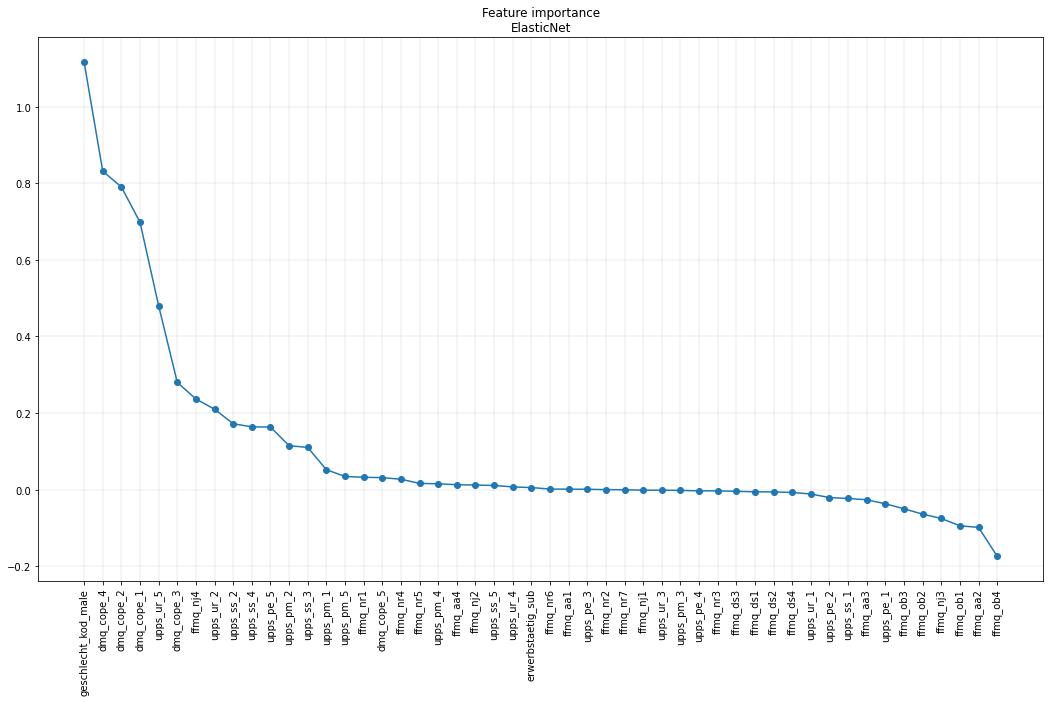

In [7]:
plot_m_imp("ElasticNet",feature_importance)

In [8]:
#plot_m_imp("RandomForestRegressor",feature_importance)

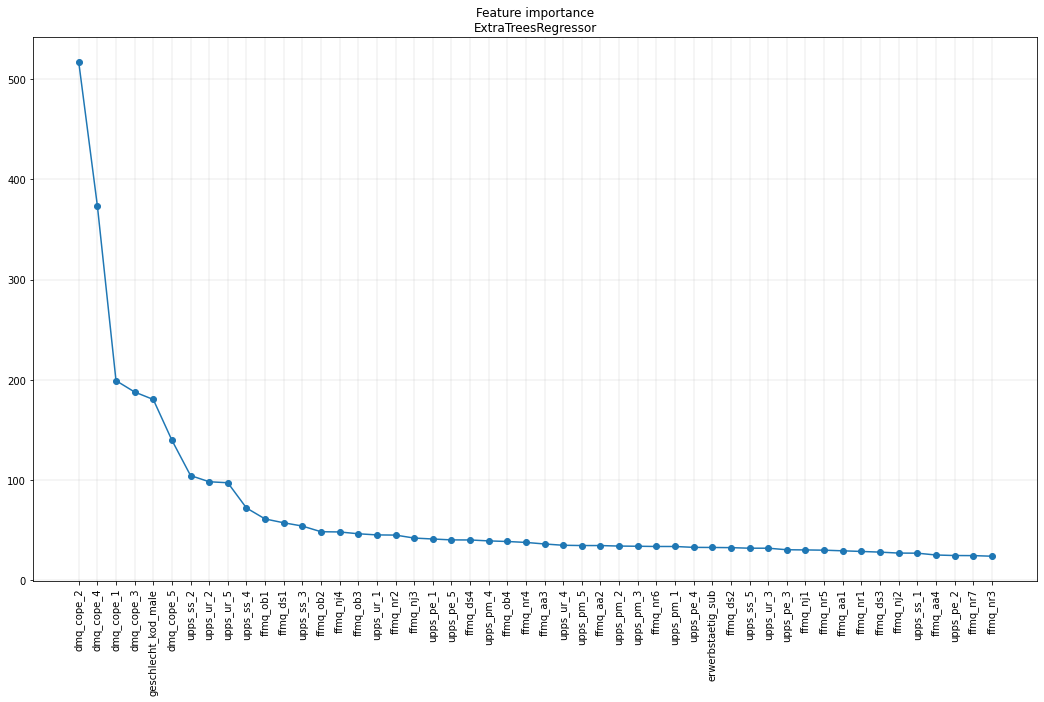

In [9]:
plot_m_imp("ExtraTreesRegressor",feature_importance)

In [10]:
#plot_m_imp("GradientBoostingRegressor",feature_importance)

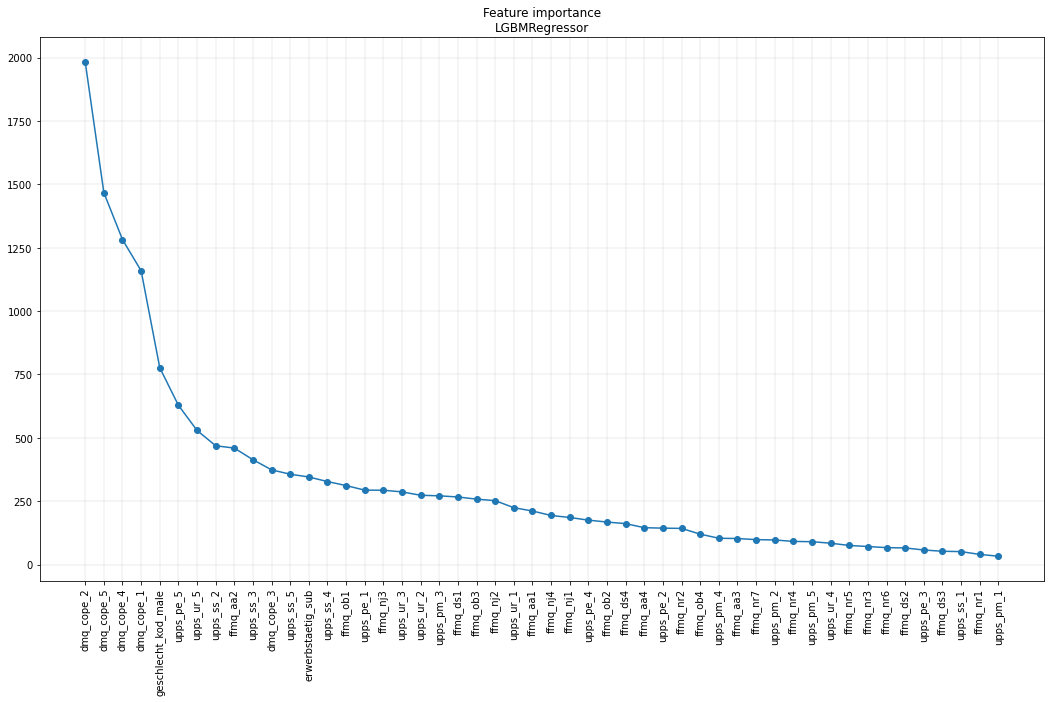

In [11]:
plot_m_imp("LGBMRegressor",feature_importance)

### SHAP importance 

**Average shap values across all splits**

In [127]:
from get_data import get_mindfulness as get_data
from utils import split_train_test
import numpy as np

X,y = get_data("complete")

# this should be taken from the original train/test splits
i_train = range(0,399)
i_test = range(399,498)

X_train, X_test = split_train_test(X, i_train, i_test)
y_train, y_test = split_train_test(y, i_train, i_test)

In [12]:
import shap
from glob import glob

feature_names = [key for key in feature_importance[list(feature_importance.keys())[0]][1]["s_imp"].keys()]

def get_avg_shap_values(reg):
    s_imp_files = glob(results_path + reg + "_" + "*" + "_s_imp.json")
    splits = len(s_imp_files)

    shap_values = np.array([])

    for s_imp_file in s_imp_files:
        with open(s_imp_file, "r") as fo:
            shap_values_new = np.array(json.load(fo))
            if len(shap_values) == 0:
                shap_values = shap_values_new
            else:
                # average step 1/2: sum
                shap_values += shap_values_new

    # average step 2/2: divide by n splits             
    shap_values /= splits
    
    return shap_values 

def plot_hist(shap_values,nrows=9,ncols=6):

    plt.subplots(nrows,ncols,figsize=(18,24),sharex=True,sharey=True)

    for i in range(len(shap_values.T)):

        plt.subplot(nrows,ncols,i + 1)
        plt.hist(shap_values.T[i], bins=5)
        plt.title(feature_names[i])
        
def summary_top_features(shap_values,feature_names,top_x=10):
    shap_sum = np.abs(shap_values).mean(axis=0)

    importance_df = pd.DataFrame([feature_names, shap_sum.tolist()]).T

    importance_df.columns = ['feature', 'shap_importance']
    importance_df = importance_df.sort_values('shap_importance', ascending=False).head(top_x).reset_index(drop=True)
    importance_df.index += 1
    print(importance_df,"\n")


 ElasticNet 

                feature shap_importance
1            dmq_cope_2        0.130538
2            dmq_cope_4        0.128375
3            dmq_cope_1        0.093658
4   geschlecht_kod_male        0.083114
5             upps_ur_5        0.054873
6              ffmq_nj4        0.043385
7            dmq_cope_3        0.039824
8             upps_ss_2        0.031416
9             upps_pe_5        0.027206
10            upps_ss_4        0.026408 



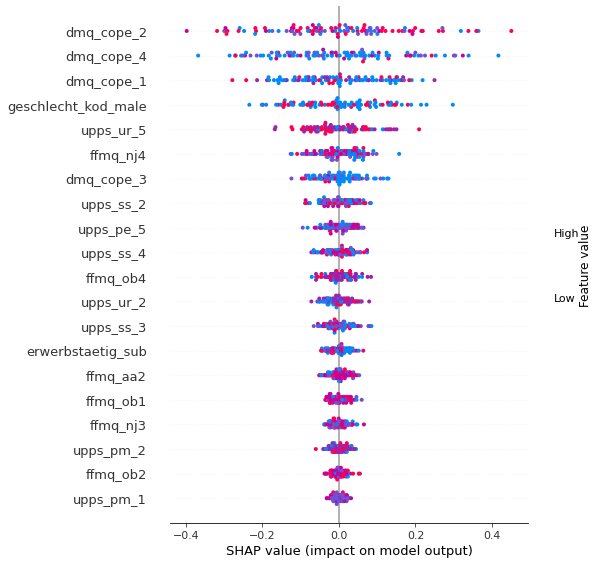

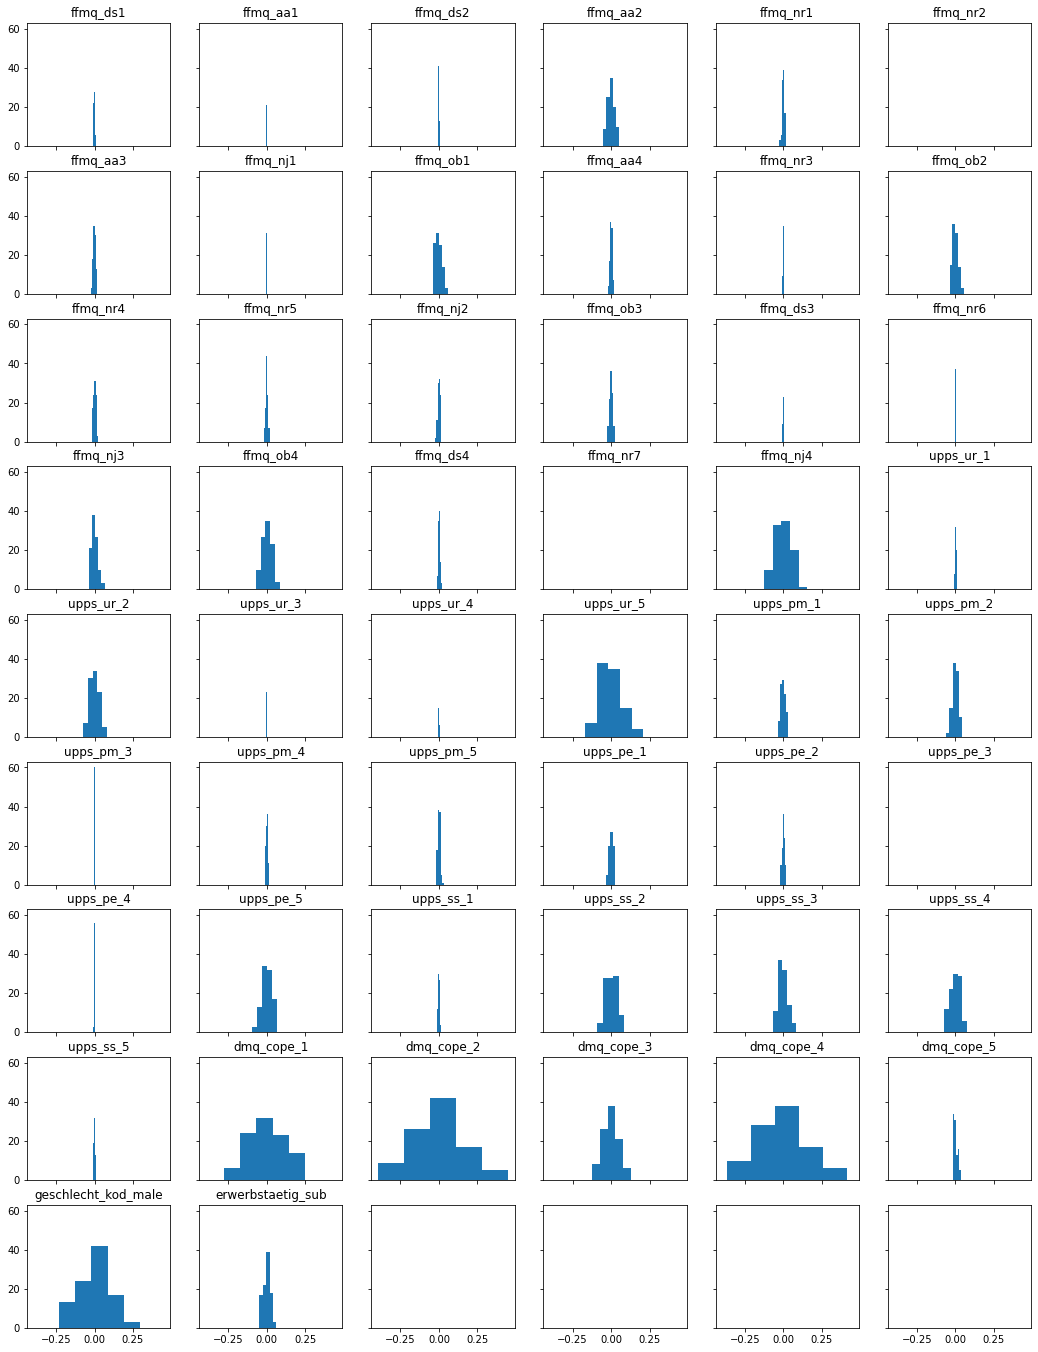

In [140]:
reg = "ElasticNet"

print("\n",reg,"\n")
shap_values = get_avg_shap_values(reg)
summary_top_features(shap_values,feature_names)
shap.summary_plot(shap_values,features=X_test, feature_names=feature_names, title=reg)
#shap.summary_plot(shap_values,feature_names=feature_names, title=reg, plot_type="violin")
plot_hist(shap_values)

**not sure about this approach to make the waterfall plot**

In [24]:
results.iloc[0,0]

'ElasticNet(alpha=0.1930248160855201, l1_ratio=1.0)'

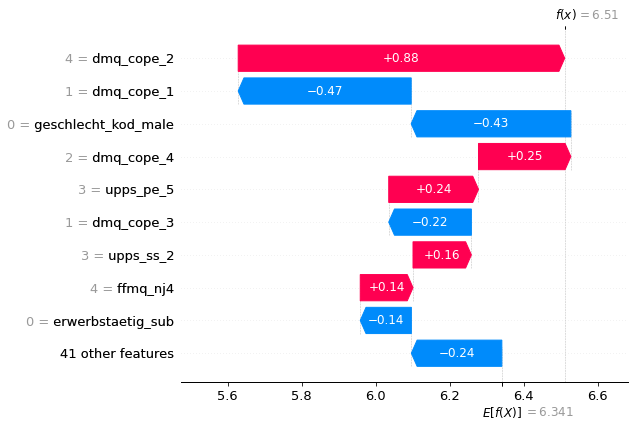

In [131]:
from sklearn.linear_model import ElasticNet


model = ElasticNet(alpha=0.1930248160855201, l1_ratio=1.0)
model.fit(X_train,y_train)

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])


 LGBMRegressor 

                feature shap_importance
1            dmq_cope_2        0.130538
2            dmq_cope_4        0.128375
3            dmq_cope_1        0.093658
4   geschlecht_kod_male        0.083114
5             upps_ur_5        0.054873
6              ffmq_nj4        0.043385
7            dmq_cope_3        0.039824
8             upps_ss_2        0.031416
9             upps_pe_5        0.027206
10            upps_ss_4        0.026408 



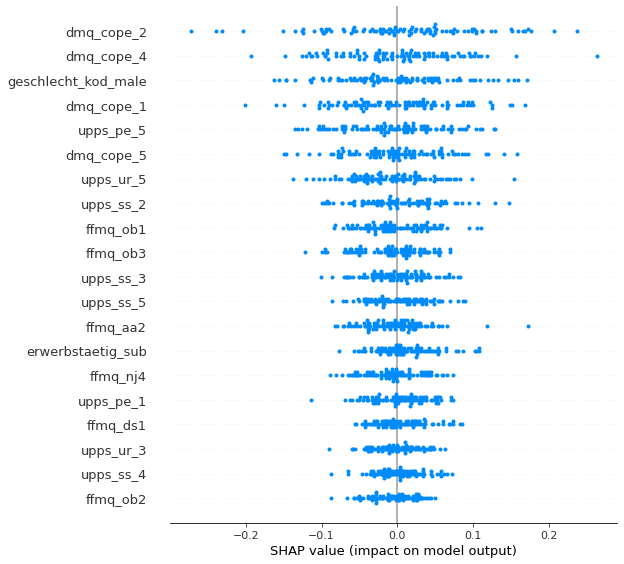

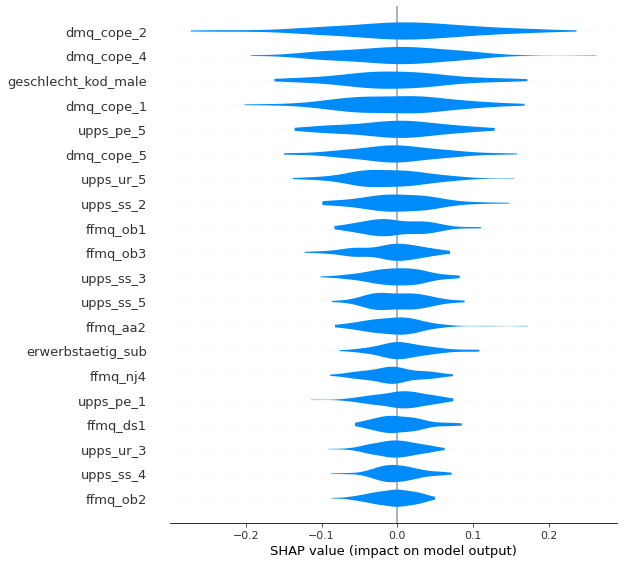

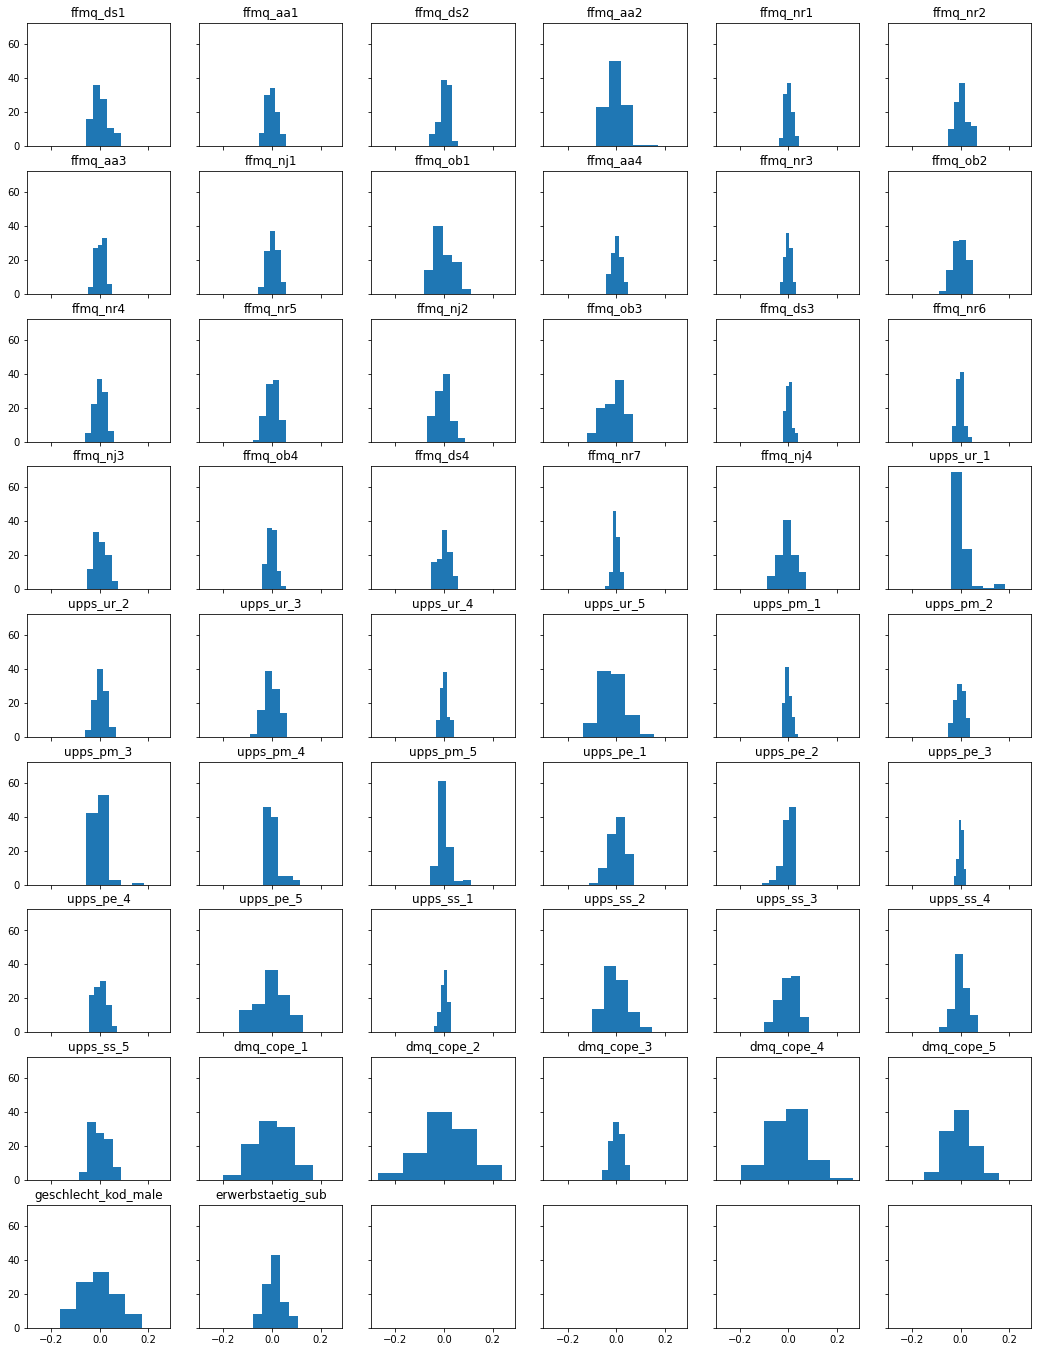

In [134]:
reg = "LGBMRegressor"

print("\n",reg,"\n")
summary_top_features(shap_values,feature_names)
shap_values = get_avg_shap_values(reg)
shap.summary_plot(shap_values,feature_names=feature_names, title=reg)
shap.summary_plot(shap_values,feature_names=feature_names, title=reg, plot_type="violin")
plot_hist(shap_values)


 ExtraTreesRegressor 

                feature shap_importance
1            dmq_cope_2        0.142624
2            dmq_cope_4        0.110319
3   geschlecht_kod_male        0.072208
4            dmq_cope_1        0.056981
5            dmq_cope_3        0.053169
6             upps_ss_2        0.040639
7            dmq_cope_5        0.036162
8             upps_ur_2        0.031455
9             upps_ur_5          0.0268
10            upps_ss_4        0.026207 



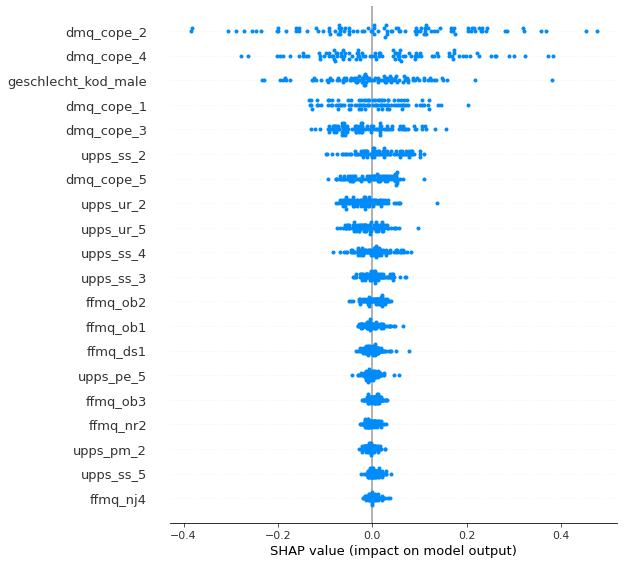

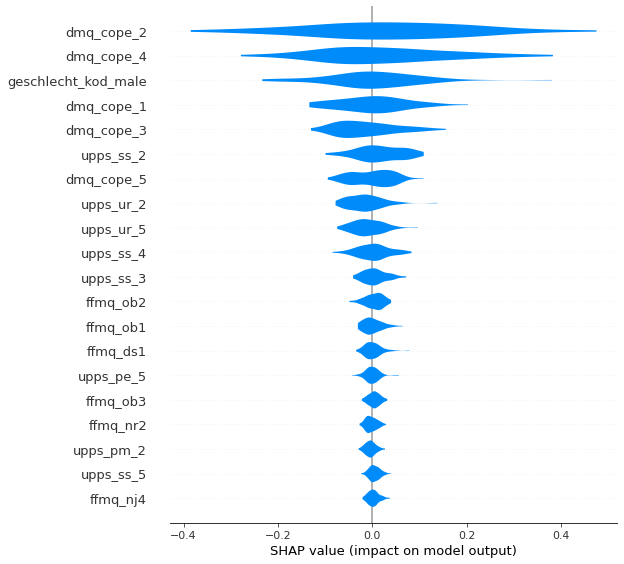

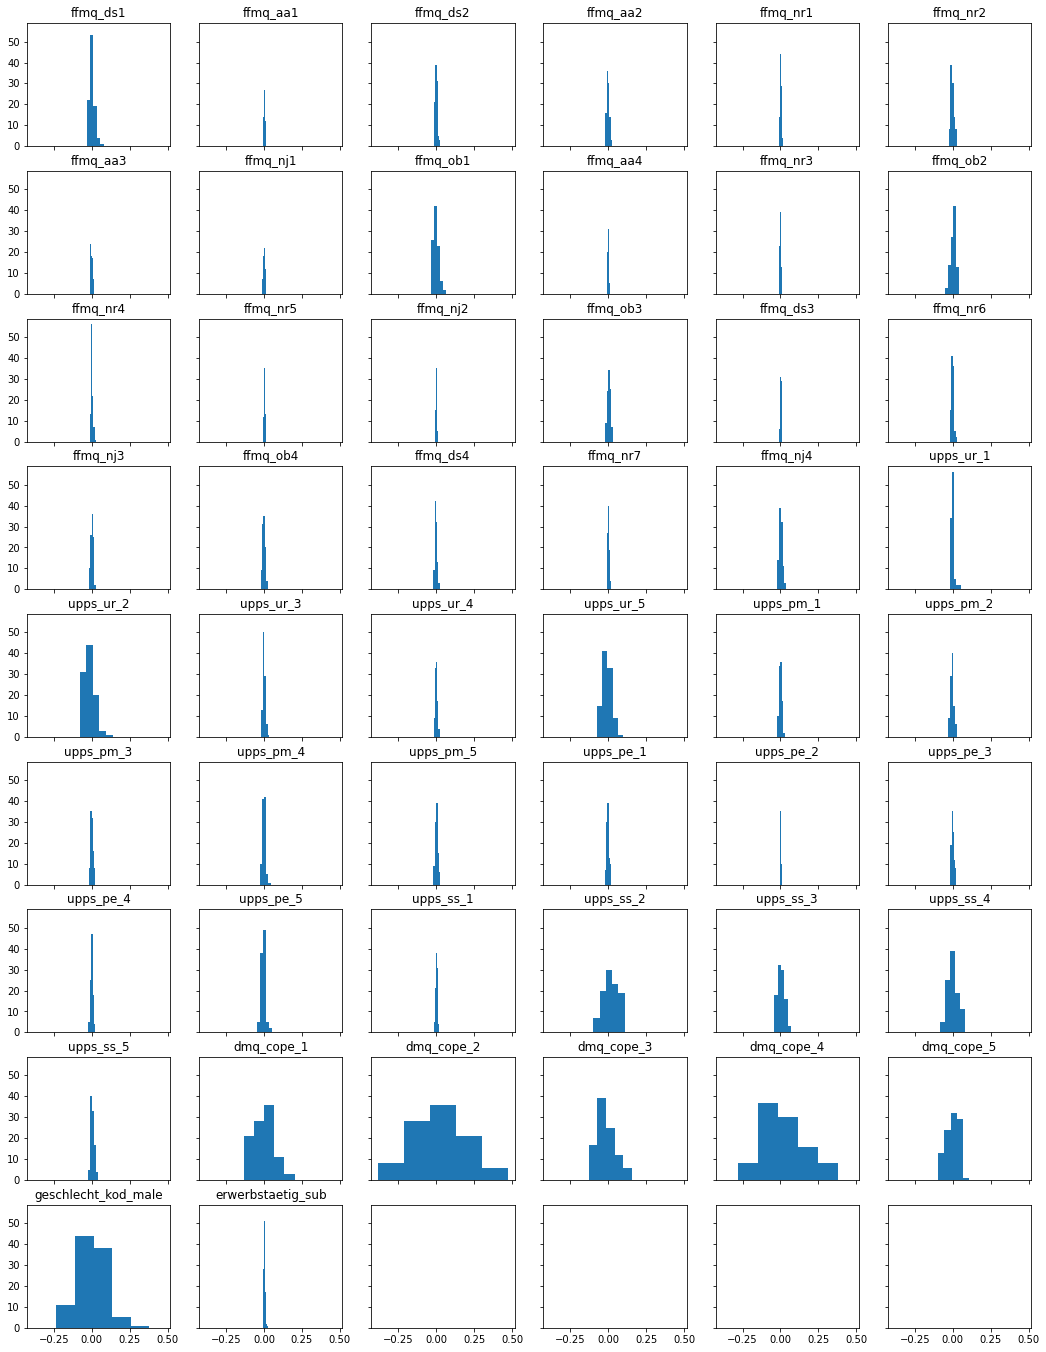

In [135]:
reg = "ExtraTreesRegressor"

print("\n",reg,"\n")
shap_values = get_avg_shap_values(reg)
summary_top_features(shap_values,feature_names)
shap.summary_plot(shap_values,feature_names=feature_names, title=reg)
shap.summary_plot(shap_values,feature_names=feature_names, title=reg, plot_type="violin")
plot_hist(shap_values)